## Kinematic Landmark Extraction with fixed ROI for Hand Detection

This script performs Kinematic Landmark Extraction and Annotation using video recordings from multiple cameras. It focuses on detecting and analyzing human pose (right shoulder and elbow) and hand movements (21 key points) within fixed Regions of Interest (ROIs).

- **Data Collection:** Extracts pose and hand landmarks from synchronized video recordings using MediaPipe Hand and Pose models.
- **Filtering & Smoothing:** Applies noise reduction, interpolation, and moving average smoothing to ensure consistency in landmark trajectories.
- **Annotation:** Annotates video frames with pose skeletons, hand landmarks, and fixed ROIs, saving the results as videos.
- **Data Saving:** Exports filtered kinematic data as .npy files for further analysis.
- **Debugging:** Displays example annotated frames for all three cameras.

Skipping calibration folder: recording_12_12_18_gmt+1_calibration

Participant: P(7), Session: session_2024-11-18_12_10_28, Recording: recording_12_14_59.870
Pose (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(7)\Kinematic Landmarks\pose_landmarks_12_14_59.870.npy
Hand (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(7)\Kinematic Landmarks\hand_landmarks_12_14_59.870.npy
--------------------------------------------------------------------------------

Participant: P(7), Session: session_2024-11-18_12_19_18, Recording: recording_12_20_37.501
Pose (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(7)\Kinematic Landmarks\pose_landmarks_12_20_37.501.npy
Hand (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(7)\Kinematic Landmarks\hand_landmarks_12_20_37.501.npy
---------------------------------------------

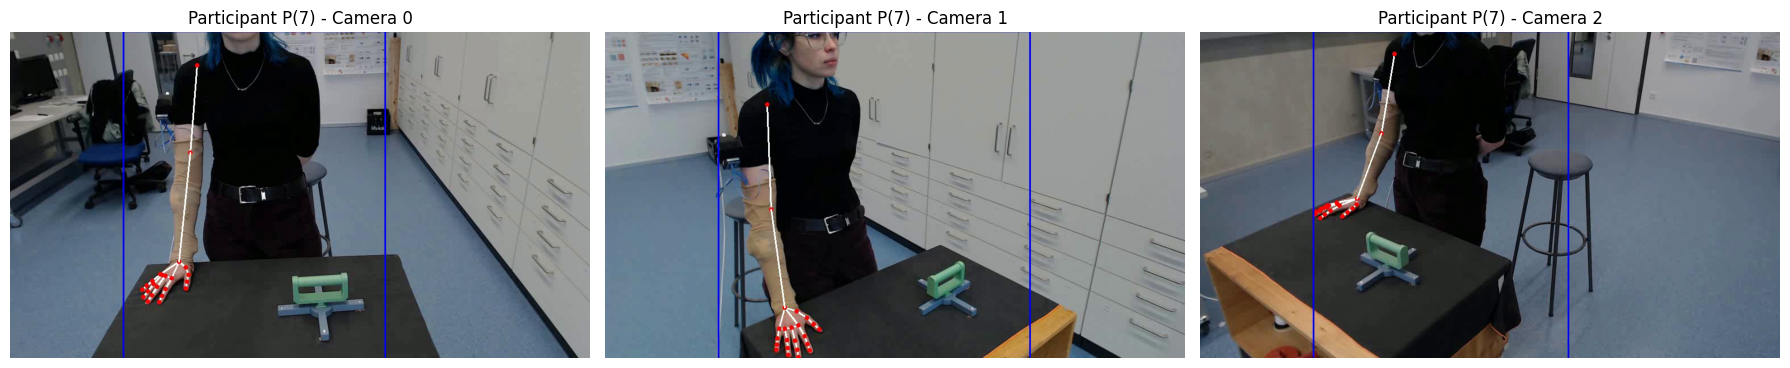

Finished participant: P(7)

Skipping calibration folder: recording_14_35_51_gmt+1_calibration

Participant: P(8), Session: session_2024-11-18_14_15_03, Recording: recording_14_48_42.500
Pose (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(8)\Kinematic Landmarks\pose_landmarks_14_48_42.500.npy
Hand (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(8)\Kinematic Landmarks\hand_landmarks_14_48_42.500.npy
--------------------------------------------------------------------------------

Participant: P(8), Session: session_2024-11-18_14_15_03, Recording: recording_14_53_18.500
Pose (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(8)\Kinematic Landmarks\pose_landmarks_14_53_18.500.npy
Hand (filtered) => C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(8)\Kinematic Landmarks\hand_landmarks_14_53_18.500.npy
-----------------

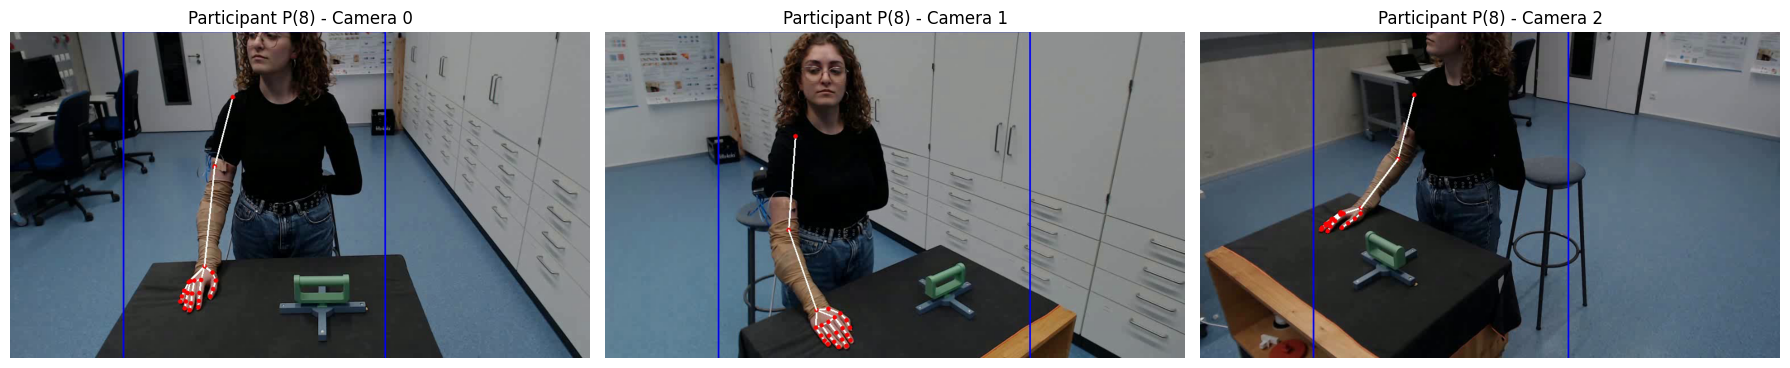

Finished participant: P(8)



In [2]:
import os
import csv
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# MediaPipe Tasks for HandLandmarker
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import copy

# --------------------------------------------------------------------------------------
# 1) Setup: root paths and participants
# --------------------------------------------------------------------------------------

root_data_path = r"C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data"
participants = [f"P({i})" for i in range(1, 9)]
model_path = r'C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\Scripts\hand_landmarker.task'

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands  # For HAND_CONNECTIONS
mp_drawing = mp.solutions.drawing_utils

pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=False,
    min_detection_confidence=0.8,
    min_tracking_confidence=0.8
)

with open(model_path, 'rb') as f:
    model_bytes = f.read()
base_options = python.BaseOptions(model_asset_buffer=model_bytes)
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    min_hand_detection_confidence=0.15,
    min_hand_presence_confidence=0.15,
    min_tracking_confidence=0.15,
    running_mode=vision.RunningMode.IMAGE
)
hand_landmarker = vision.HandLandmarker.create_from_options(options)

# --------------------------------------------------------------------------------------
# 2) Side-flip correction
# --------------------------------------------------------------------------------------

def correct_side_flip(pose_landmarks, facing_camera=True):
    if len(pose_landmarks) < 33:
        return
    left_idx  = mp_pose.PoseLandmark.LEFT_SHOULDER.value  # 11
    right_idx = mp_pose.PoseLandmark.RIGHT_SHOULDER.value # 12
    Lx = pose_landmarks[left_idx].x
    Rx = pose_landmarks[right_idx].x

    do_flip = False
    if facing_camera:
        do_flip = (Lx < Rx)
    else:
        do_flip = (Lx > Rx)

    if do_flip:
        symmetrical_pairs = [
            (11, 12),  # shoulders
            (13, 14),  # elbows
            (15, 16),  # wrists
            (23, 24),  # hips
            (25, 26),  # knees
            (27, 28),  # ankles
            (29, 30),  # heels
            (31, 32),  # foot index
        ]
        for (l_idx, r_idx) in symmetrical_pairs:
            temp_left  = copy.copy(pose_landmarks[l_idx])
            temp_right = copy.copy(pose_landmarks[r_idx])
            pose_landmarks[l_idx].CopyFrom(temp_right)
            pose_landmarks[r_idx].CopyFrom(temp_left)

# --------------------------------------------------------------------------------------
# 3) Outlier removal + interpolation + smoothing
# --------------------------------------------------------------------------------------

def moving_average_1d(values, window_size=10):
    """
    Simple moving average on a 1D list. Edges are padded by nearest neighbor for simplicity.
    """
    n = len(values)
    if n == 0 or window_size < 2:
        return values[:]
    half = window_size // 2
    smoothed = []
    for i in range(n):
        start = max(0, i - half)
        end   = min(n, i + half + 1)
        window_vals = values[start:end]
        avg = sum(window_vals) / len(window_vals)
        smoothed.append(avg)
    return smoothed

def fill_nones(array, fill=0.0):
    """
    Helper to fill None entries with the last known good value or a default fill if none exist yet.
    """
    last_good = None
    for i in range(len(array)):
        if array[i] is None:
            array[i] = last_good if last_good is not None else fill
        else:
            last_good = array[i]

def filter_and_smooth_landmarks(all_landmarks, 
                                pose_max_jump=30.0, 
                                pose_ma_window=15, 
                                hand_max_jump=30.0, 
                                hand_ma_window=10):
    """
    - all_landmarks is [frame][camera] with 'pose_landmarks' and 'hand_landmarks'.
    - We do outlier removal & interpolation, then moving average, for each dimension (x,y,z).
    - Separate parameters for pose and hand so we can fine-tune them individually.
    """

    if not all_landmarks:
        return

    num_frames = len(all_landmarks)
    num_cams   = len(all_landmarks[0])  # assumed consistent

    # ----- Filter Pose Landmarks (shoulder, elbow) across time -----
    pose_keys = ['right_shoulder', 'right_elbow']

    for cam_idx in range(num_cams):
        for pk in pose_keys:
            x_vals = []
            y_vals = []
            z_vals = []
            for f_idx in range(num_frames):
                ldict = all_landmarks[f_idx][cam_idx]['pose_landmarks']
                if pk in ldict and len(ldict[pk]) == 3:
                    x_vals.append(ldict[pk][0])
                    y_vals.append(ldict[pk][1])
                    z_vals.append(ldict[pk][2])
                else:
                    x_vals.append(None)
                    y_vals.append(None)
                    z_vals.append(None)

            # Fill missing data
            fill_nones(x_vals)
            fill_nones(y_vals)
            fill_nones(z_vals)

            # Moving average
            x_vals = moving_average_1d(x_vals, pose_ma_window)
            y_vals = moving_average_1d(y_vals, pose_ma_window)
            z_vals = moving_average_1d(z_vals, pose_ma_window)

            # Save the smoothed values back
            for f_idx in range(num_frames):
                all_landmarks[f_idx][cam_idx]['pose_landmarks'].setdefault(pk, [0,0,0])
                all_landmarks[f_idx][cam_idx]['pose_landmarks'][pk][0] = x_vals[f_idx]
                all_landmarks[f_idx][cam_idx]['pose_landmarks'][pk][1] = y_vals[f_idx]
                all_landmarks[f_idx][cam_idx]['pose_landmarks'][pk][2] = z_vals[f_idx]

    # ----- Filter Hand Landmarks across time -----
    for cam_idx in range(num_cams):
        for landmark_i in range(21):  # up to 21 hand landmarks
            x_vals = []
            y_vals = []
            z_vals = []
            for f_idx in range(num_frames):
                hlist = all_landmarks[f_idx][cam_idx]['hand_landmarks']
                if 0 <= landmark_i < len(hlist):
                    coords = hlist[landmark_i]
                    if len(coords) == 3:
                        x_vals.append(coords[0])
                        y_vals.append(coords[1])
                        z_vals.append(coords[2])
                    else:
                        x_vals.append(None)
                        y_vals.append(None)
                        z_vals.append(None)
                else:
                    x_vals.append(None)
                    y_vals.append(None)
                    z_vals.append(None)

            # Fill missing
            fill_nones(x_vals)
            fill_nones(y_vals)
            fill_nones(z_vals)

            # Moving average
            x_vals = moving_average_1d(x_vals, hand_ma_window)
            y_vals = moving_average_1d(y_vals, hand_ma_window)
            z_vals = moving_average_1d(z_vals, hand_ma_window)

            # Save
            for f_idx in range(num_frames):
                hlist = all_landmarks[f_idx][cam_idx]['hand_landmarks']
                if len(hlist) <= landmark_i:
                    needed = landmark_i - len(hlist) + 1
                    for _ in range(needed):
                        hlist.append([0,0,0])
                hlist[landmark_i][0] = x_vals[f_idx]
                hlist[landmark_i][1] = y_vals[f_idx]
                hlist[landmark_i][2] = z_vals[f_idx]

# --------------------------------------------------------------------------------------
# 4) Two-pass approach: (A) Collect raw data, (B) Filter & smooth, (C) Annotate & save
# --------------------------------------------------------------------------------------

# -----------------------
# Helper Functions
# -----------------------

def read_frames_from_captures(caps):
    """
    Reads one frame from each capture in 'caps'.
    Returns a list of frames if all captures read successfully, 
    otherwise returns an empty list.
    """
    frames = []
    for cap in caps:
        ret, frame = cap.read()
        if not ret:
            return []
        frames.append(frame)
    return frames

def detect_pose_in_frame(frame, w, h, pose_detector):
    """
    Runs Pose detection on the full frame.
    Returns a dict with 'right_shoulder' and 'right_elbow' 
    if detection is successful, otherwise returns an empty dict.
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_pose = pose_detector.process(frame_rgb)

    pose_landmarks = {}
    if results_pose.pose_landmarks:
        # Flip if necessary
        plms = results_pose.pose_landmarks.landmark
        correct_side_flip(plms, facing_camera=True)

        # Indices for right shoulder & right elbow
        RSHO = mp_pose.PoseLandmark.RIGHT_SHOULDER.value
        RELB = mp_pose.PoseLandmark.RIGHT_ELBOW.value

        def px_coords(lm):
            return [lm.x * w, lm.y * h, lm.z * w]

        rshoulder = px_coords(plms[RSHO])
        relbow    = px_coords(plms[RELB])

        pose_landmarks = {
            'right_shoulder': rshoulder,
            'right_elbow':    relbow
        }
    return pose_landmarks

def draw_pose_on_frame(frame, rshoulder, relbow, line_color=(255,255,255), circle_color=(0,0,255)):
    """
    Draws a line from shoulder to elbow on 'frame' and
    red circles at those points.
    """
    cv2.line(frame,
             (int(rshoulder[0]), int(rshoulder[1])),
             (int(relbow[0]),    int(relbow[1])),
             line_color, 2)
    for coords in [rshoulder, relbow]:
        cv2.circle(frame, (int(coords[0]), int(coords[1])), 4, circle_color, -1)

def detect_hand_in_roi(frame, roi, w, h, hand_detector):
    """
    Runs hand detection on a fixed ROI within 'frame'. 
    'roi' is a dict with x_min, y_min, x_max, y_max.
    Returns a list of 21 hand landmark coords in the full image space 
    if detection is successful, otherwise returns [].
    """
    x_min = max(0, roi['x_min'])
    y_min = max(0, roi['y_min'])
    x_max = min(w, roi['x_max'])
    y_max = min(h, roi['y_max'])

    roi_bgr = frame[y_min:y_max, x_min:x_max]
    if roi_bgr.size == 0:
        return []

    roi_rgb = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2RGB)
    roi_h, roi_w, _ = roi_rgb.shape
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=roi_rgb)
    results_hands = hand_detector.detect(mp_image)

    if results_hands.hand_landmarks:
        
        hand_lms = results_hands.hand_landmarks[0]
        hand_coords = []
        for lm in hand_lms:
            X = lm.x * roi_w + x_min
            Y = lm.y * roi_h + y_min
            Z = lm.z * roi_w
            hand_coords.append([X, Y, Z])
        return hand_coords
    return []

def draw_hand_on_frame(frame, hand_coords, line_color=(255,255,255), circle_color=(0,0,255)):
    """
    Draws the 21 hand landmarks + the skeleton on 'frame'.
    'hand_coords' is a list of 21 [X, Y, Z].
    """
    # Skeleton connections from MediaPipe
    for connection in mp_hands.HAND_CONNECTIONS:
        start_idx, end_idx = connection
        if start_idx < len(hand_coords) and end_idx < len(hand_coords):
            s_xy = hand_coords[start_idx]
            e_xy = hand_coords[end_idx]
            cv2.line(frame,
                     (int(s_xy[0]), int(s_xy[1])),
                     (int(e_xy[0]), int(e_xy[1])),
                     line_color, 2)
    # Draw the landmarks as circles
    for xy in hand_coords:
        cv2.circle(frame, (int(xy[0]), int(xy[1])), 4, circle_color, -1)

# -----------------------
# Main Processing Functions
# -----------------------

def collect_raw_data(video_paths, participant):
    """
    Reads frames from each camera, runs Pose & Hand detection within fixed ROIs,
    stores frames + raw landmarks.
    Returns (frames_in_memory, all_landmarks).
    """
    caps = [cv2.VideoCapture(p) for p in video_paths]
    frames_in_memory = [[] for _ in video_paths]
    all_landmarks = []  # all_landmarks[frame_idx][camera_idx]

    lens = [int(c.get(cv2.CAP_PROP_FRAME_COUNT)) for c in caps]
    min_len = min(lens)

    # ------------------------------------------------------------------
    # Define default ROIs
    # ------------------------------------------------------------------
    fixed_rois = [
        {'x_min': 200, 'y_min': 0, 'x_max': 530, 'y_max': 700},  # Camera 0
        {'x_min': 200, 'y_min': 0, 'x_max': 600, 'y_max': 700},  # Camera 1
        {'x_min': 200, 'y_min': 0, 'x_max': 650, 'y_max': 700},  # Camera 2
    ]

    # ------------------------------------------------------------------
    # For participant P(7) or P(8), enlarge camera 0 and 1 by 25%
    # ------------------------------------------------------------------
    if participant in ["P(7)", "P(8)"]:
        fixed_rois[0]['x_max'] = int(fixed_rois[0]['x_max'] * 1.25)  # enlarge ROI camera 0
        fixed_rois[1]['x_max'] = int(fixed_rois[1]['x_max'] * 1.25)  # enlarge ROI camera 1

    frame_idx = 0
    while True:
        frames = read_frames_from_captures(caps)
        if len(frames) != len(video_paths):
            break  # Reached end of at least one video

        # Store frames in memory
        for ci, frm in enumerate(frames):
            frames_in_memory[ci].append(frm)

        # Detect landmarks
        landmarks_per_camera = []
        for ci, frm in enumerate(frames):
            h, w, _ = frm.shape

            # Current ROI for this camera
            roi = fixed_rois[ci]

            # Pose Detection
            pose_landmarks = detect_pose_in_frame(frm, w, h, pose)

            # Hand Detection within fixed ROI
            hand_landmarks = detect_hand_in_roi(frm, roi, w, h, hand_landmarker)

            # Store landmarks
            dict_cam = {
                'camera_index': ci,
                'frame_index': frame_idx,
                'pose_landmarks': pose_landmarks,
                'hand_landmarks': hand_landmarks
            }
            landmarks_per_camera.append(dict_cam)

        all_landmarks.append(landmarks_per_camera)
        frame_idx += 1
        if frame_idx >= min_len:
            break

    for c in caps:
        c.release()

    return frames_in_memory, all_landmarks

def annotate_frames_and_save(frames_in_memory, all_landmarks, output_video_paths, participant):
    """
    Second pass: draws the *filtered* landmarks from all_landmarks onto frames,
    draws fixed ROIs, and writes annotated videos.
    """
    # Define fixed ROIs for each camera here:
    fixed_rois = [
        {'x_min': 200, 'y_min': 0,   'x_max': 530, 'y_max': 700},  # Camera 0
        {'x_min': 200, 'y_min': 0,   'x_max': 600, 'y_max': 700},  # Camera 1
        {'x_min': 200, 'y_min': 0,   'x_max': 650, 'y_max': 700}   # Camera 2
    ]

    # For participant P(7) or P(8), enlarge camera 0 and 1 by 25%
    if participant in ["P(7)", "P(8)"]:
        fixed_rois[0]['x_max'] = int(fixed_rois[0]['x_max'] * 1.25)
        fixed_rois[1]['x_max'] = int(fixed_rois[1]['x_max'] * 1.25)

    video_writers = []
    for path_idx, out_path in enumerate(output_video_paths):
        if len(frames_in_memory[path_idx]) == 0:
            video_writers.append(None)
            continue
        h, w, _ = frames_in_memory[path_idx][0].shape
        writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), 31.2, (w, h))
        video_writers.append(writer)

    num_frames = len(all_landmarks)
    num_cams = len(frames_in_memory)

    for f_idx in range(num_frames):
        for cam_idx in range(num_cams):
            if cam_idx >= len(video_writers) or video_writers[cam_idx] is None:
                continue
            frame = frames_in_memory[cam_idx][f_idx].copy()  # BGR copy
            data_dict = all_landmarks[f_idx][cam_idx]
            pose_lms  = data_dict['pose_landmarks']
            hand_lms  = data_dict['hand_landmarks']

            # Pose: draw line from shoulder->elbow
            if pose_lms:
                rshoulder = pose_lms.get('right_shoulder', None)
                relbow    = pose_lms.get('right_elbow', None)
                if rshoulder and relbow:
                    draw_pose_on_frame(frame, rshoulder, relbow)

            # Hand: draw lines & red circles
            if hand_lms:
                draw_hand_on_frame(frame, hand_lms)

                # Connect elbow (Pose) → wrist (Hand landmark 0) if present
                if pose_lms and len(hand_lms) > 0:
                    relbow = pose_lms.get('right_elbow', None)
                    if relbow:
                        hand_wrist = hand_lms[0]  # wrist is index 0
                        cv2.line(
                            frame,
                            (int(relbow[0]), int(relbow[1])),
                            (int(hand_wrist[0]), int(hand_wrist[1])),
                            (255, 255, 255), 2
                        )

            # Draw the FIXED ROI in blue
            if cam_idx < len(fixed_rois):
                roi = fixed_rois[cam_idx]
                x_min, y_min, x_max, y_max = roi['x_min'], roi['y_min'], roi['x_max'], roi['y_max']
                cv2.rectangle(
                    frame,
                    (x_min, y_min),
                    (x_max, y_max),
                    (255, 0, 0), 2  # Blue in BGR
                )

            video_writers[cam_idx].write(frame)

    for vw in video_writers:
        if vw is not None:
            vw.release()

# --------------------------------------------------------------------------------------
# 5) Debug/Plot function: show an example annotated frame for each camera
# --------------------------------------------------------------------------------------

def debug_finish_participant(participant, annotated_video_paths):
    """
    Shows a single example annotated frame for each camera (if available) using Matplotlib,
    and prints a message indicating the participant is finished.
    """
    print(f"==> All sessions for participant {participant} are done. Debug frame check below...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for cam_idx in range(3):
        ax = axes[cam_idx]
        if cam_idx < len(annotated_video_paths) and os.path.exists(annotated_video_paths[cam_idx]):
            cap = cv2.VideoCapture(annotated_video_paths[cam_idx])
            ret, frame_bgr = cap.read()
            cap.release()
            if ret and frame_bgr is not None:
                frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                ax.imshow(frame_rgb)
                ax.set_title(f"Participant {participant} - Camera {cam_idx}")
                ax.axis('off')
            else:
                ax.set_title(f"No frame read from annotated Cam {cam_idx}")
                ax.axis('off')
        else:
            ax.set_title(f"No annotated video for Cam {cam_idx}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Finished participant: {participant}\n")

# --------------------------------------------------------------------------------------
# 6) Code Execution with main()
# --------------------------------------------------------------------------------------

def main():
    for participant in participants:
        sessions_dir = os.path.join(root_data_path, participant, "Camera Data Timestamped", "recording_sessions")
        if not os.path.exists(sessions_dir):
            print(f"Sessions directory not found for participant {participant}. Skipping.")
            continue

        kinematic_landmarks_dir = os.path.join(root_data_path, participant, "Kinematic Landmarks")
        os.makedirs(kinematic_landmarks_dir, exist_ok=True)

        session_folders = [
            f for f in os.listdir(sessions_dir)
            if f.startswith("session_") and os.path.isdir(os.path.join(sessions_dir, f))
        ]

        # We'll track annotated videos from the LAST recording for debugging
        annotated_paths_for_debug = None

        for session_folder in session_folders:
            session_path = os.path.join(sessions_dir, session_folder)
            recording_folders = [
                f for f in os.listdir(session_path)
                if f.startswith("recording_") and os.path.isdir(os.path.join(session_path, f))
            ]
            for recording_folder in recording_folders:
                # ----------------------------------------------------
                # (1) Skip calibration recordings
                # ----------------------------------------------------
                if "calibration" in recording_folder.lower():
                    print(f"Skipping calibration folder: {recording_folder}")
                    continue

                recording_path = os.path.join(session_path, recording_folder)
                timestamp = recording_folder.replace("recording_", "")
                sync_folder = os.path.join(recording_path, "synchronized_videos")

                vid0 = os.path.join(sync_folder, "Camera_000_synchronized.mp4")
                vid1 = vid0.replace("Camera_000", "Camera_001")
                vid2 = vid0.replace("Camera_000", "Camera_002")

                if not (os.path.exists(vid0) and os.path.exists(vid1) and os.path.exists(vid2)):
                    print(f"Synchronized videos not found for {recording_folder} in {participant}. Skipping.")
                    continue

                # Pass 1: collect raw
                video_paths = [vid0, vid1, vid2]
                frames_in_memory, all_landmarks = collect_raw_data(video_paths, participant)

                # Filter & smooth
                filter_and_smooth_landmarks(
                    all_landmarks,
                    pose_max_jump=30.0,    # e.g., 30 px max jump
                    pose_ma_window=10,     # smoothing window for pose
                    hand_max_jump=30.0,    # consistent with pose
                    hand_ma_window=5       # smaller window for hands
                )

                # Pass 2: annotate & save
                out_anno_dir = os.path.join(recording_path, f"annotated_videos_{timestamp}")
                os.makedirs(out_anno_dir, exist_ok=True)

                out_vid0 = os.path.join(out_anno_dir, "annotated_video_camera_0.avi")
                out_vid1 = os.path.join(out_anno_dir, "annotated_video_camera_1.avi")
                out_vid2 = os.path.join(out_anno_dir, "annotated_video_camera_2.avi")
                output_video_paths = [out_vid0, out_vid1, out_vid2]

                annotate_frames_and_save(frames_in_memory, all_landmarks, output_video_paths, participant)

                annotated_paths_for_debug = output_video_paths 

                # ----------------------------------------------------------------
                # (2) Save only the .npy files (remove CSV-writing part)
                # ----------------------------------------------------------------
                pose_data = []
                hand_data = []
                for frame_set in all_landmarks:
                    for cam_dict in frame_set:
                        f_idx = cam_dict['frame_index']
                        c_idx = cam_dict['camera_index']
                        pose_lms = cam_dict['pose_landmarks']
                        if pose_lms:
                            rs = pose_lms['right_shoulder']
                            re = pose_lms['right_elbow']
                            row = [f_idx, c_idx, rs[0], rs[1], rs[2], re[0], re[1], re[2]]
                            pose_data.append(row)

                        h_lms = cam_dict['hand_landmarks']
                        for i, coords in enumerate(h_lms):
                            row = [f_idx, c_idx, i, coords[0], coords[1], coords[2]]
                            hand_data.append(row)

                pose_array = np.array(pose_data) if pose_data else np.empty((0, 8))
                hand_array = np.array(hand_data) if hand_data else np.empty((0, 6))

                pose_npy = os.path.join(kinematic_landmarks_dir, f'pose_landmarks_{timestamp}.npy')
                hand_npy = os.path.join(kinematic_landmarks_dir, f'hand_landmarks_{timestamp}.npy')

                np.save(pose_npy, pose_array)
                np.save(hand_npy,  hand_array)

                print(f"\nParticipant: {participant}, Session: {session_folder}, Recording: {recording_folder}")
                print(f"Pose (filtered) => {pose_npy}")
                print(f"Hand (filtered) => {hand_npy}")
                print("-"*80)

        # After processing all sessions for this participant, call the debug function
        if annotated_paths_for_debug is not None:
            debug_finish_participant(participant, annotated_paths_for_debug)

if __name__ == "__main__":
    main()
